In [24]:
import networkx as nx
import osmnx as ox
%matplotlib inline
import pandas as pd
import numpy as np
import os
import time
from collections import defaultdict
%config IPCompleter.use_jedi=False

In [4]:
datapath = r"../Data/data_cleaned.csv"
output_path=r"../Data/data_cleaned_processed.csv"

In [5]:
data = pd.read_csv(datapath)
data = data[["start station id", "start station name", "start station latitude", "start station longitude", "end station id", "end station name", "end station latitude", "end station longitude"]]

In [6]:
stations1 = data.groupby("start station id").first()
stations2 = data.groupby("end station id").first()

In [7]:
stations1.drop(["end station id", "end station name", "end station latitude", "end station longitude"], inplace =True, axis=1)
stations2.drop(["start station id", "end station name", "start station latitude", "start station longitude"],axis=1,inplace=True)

stations1.index.name="id"
stations2.index.name="id"
stations1=stations1.set_axis(["name", "latitude","longitude"],axis=1)
stations2=stations2.set_axis(["name", "latitude","longitude"],axis=1)

stations = pd.concat([stations1,stations2])
stations = stations[~stations.index.duplicated(keep="first")]
stations

,name,latitude,longitude
id,,,
72.0,W 52 St & 11 Ave,40.767272,-73.993929
79.0,Franklin St & W Broadway,40.719116,-74.006667
82.0,St James Pl & Pearl St,40.711174,-74.000165
83.0,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
119.0,Park Ave & St Edwards St,40.696089,-73.978034
...,...,...,...
3481.0,Mercer St & Spring St,40.716490,-74.041050
3638.0,W 116 St & Broadway,40.724294,-74.035483
3639.0,Broadway & Battery Pl,40.719252,-74.034234


In [ ]:
del data
del stations1
del stations2

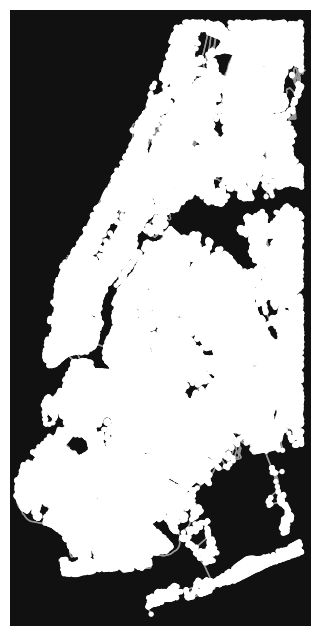

In [10]:
margin = 0.2
north = stations["latitude"].max() + margin
south = stations["latitude"].min() - margin
west = stations["longitude"].min() - margin
east = stations["longitude"].max() + margin

#Unfortunately this seems to exclude governors island
#G = ox.graph_from_place("New York, New York, USA", network_type="bike")
G = ox.graph_from_bbox(north,south,east,west,network_type="bike")
G=ox.utils_graph.get_largest_component(G,strongly=True) #Otherwise routing can fail
fig, ax = ox.plot_graph(G)

In [12]:
station_to_node = {}
station_to_dist = {}
threshold=100
failed_nodes = 0
n = 0
for i,station in stations.iterrows():
    if n % 100 == 0:
        print(n)
    if not station.name in station_to_node:
        node,dist = ox.distance.nearest_nodes(G, Y=station["latitude"], X=station["longitude"],return_dist=True)
        station_to_node[station.name] = node
        station_to_dist[station.name] = dist
        if dist > threshold:
            failed_nodes += 1 
    n+=1
print(f"{failed_nodes} nodes were not found precisely.")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
33 nodes were not found precisely.


In [13]:
nx.shortest_path_length(G,station_to_node[72.0],station_to_node[79.0],weight="length")
#google maps claims about 6.5 km

6100.81

In [17]:
stations["node"] = pd.Series(station_to_node)
stations["node_distance"] = pd.Series(station_to_dist)
stations[stations["node_distance"]>1000].count()

name             27
latitude         27
longitude        27
node             27
node_distance    27
dtype: int64

In [21]:
data_chunks = pd.read_csv("../Data/data_cleaned.csv",chunksize=1e5)

In [ ]:
#This likely takes hours
#Note that shortes_path_length is called at most about len(stations)^2 / 2 times before we have all distances in the dict.
distances = {}
n = 0
threshold = 1000
start = time.time()
for chunk in data_chunks:
    chunk["distance"] = np.nan
    for i,trip in chunk.iterrows():
        route = frozenset([trip["start station id"],trip["end station id"]])
        if not route in distances:
            node1 = station_to_node[trip["start station id"]]
            node2 = station_to_node[trip["end station id"]]
            dist1 = station_to_dist[trip["start station id"]]
            dist2 = station_to_dist[trip["end station id"]]
            if dist1 < threshold and dist2 < threshold:
                distances[route] = nx.shortest_path_length(G,node1,node2,weight="length")
            else:
                distances[route] = np.nan
        chunk.at[i,"distance"]=distances[route]
    chunk.to_csv(output_path, mode='a', header=not os.path.exists(output_path))
    n+=1
    end = time.time()
    print(f"{end-start:.0f}s: {n} chunks processed")